### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import matplotlib.pyplot as plt
import resnet

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib

NUM_GPUS = 1
BS_PER_GPU = 128
BATCH_SIZE = 128
NUM_EPOCHS = 20

IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
NUM_CLASSES = 8
NUM_TRAIN_SAMPLES = 50000

BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 30), (0.01, 45)]


def preprocess(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y


def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, HEIGHT + 8, WIDTH + 8)
    x = tf.image.random_crop(x, [HEIGHT, WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y	


def schedule(epoch):
  initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
  learning_rate = initial_learning_rate
  for mult, start_epoch in LR_SCHEDULE:
    if epoch >= start_epoch:
      learning_rate = initial_learning_rate * mult
    else:
      break
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [9]:
(x,y), (x_test, y_test) = keras.datasets.cifar10.load_data()

train_dataset_old = tf.data.Dataset.from_tensor_slices((x,y))
test_dataset_old = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [10]:
train_dataset_old = train_dataset_old.shuffle(100)

In [11]:
print(next(iter(train_dataset_old.take(1))))

(<tf.Tensor: id=142, shape=(32, 32, 3), dtype=uint8, numpy=
array([[[156, 194, 129],
        [167, 212, 127],
        [169, 215, 129],
        ...,
        [243, 247, 226],
        [230, 235, 206],
        [208, 215, 180]],

       [[174, 210, 147],
        [192, 229, 159],
        [172, 204, 163],
        ...,
        [237, 243, 223],
        [213, 221, 200],
        [186, 193, 169]],

       [[192, 234, 145],
        [194, 230, 178],
        [174, 201, 194],
        ...,
        [226, 231, 218],
        [198, 208, 186],
        [195, 200, 165]],

       ...,

       [[187, 211, 151],
        [211, 234, 180],
        [231, 244, 221],
        ...,
        [210, 204, 199],
        [217, 208, 210],
        [203, 192, 192]],

       [[231, 238, 218],
        [220, 236, 209],
        [200, 219, 177],
        ...,
        [183, 170, 153],
        [189, 175, 160],
        [186, 169, 153]],

       [[238, 242, 224],
        [238, 247, 232],
        [229, 239, 217],
        ...,
        [141, 

In [ ]:
for image, label in train_dataset_old.take(2):
    plt.figure()
    plt.imshow(image.numpy())
    #print(repr(image.numpy()))
    print(label)
    #print(class_names[np.where(label)])

In [2]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('*/*.png')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])

# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [207]:
class_names

array(['Anatomic landmarks', 'Unknown', 'Protruding lesions',
       'Flat lesions', 'Lumen', 'Mucosa', 'Normal', 'Excavated lesions'],
      dtype='<U18')

In [ ]:
parts = tf.strings.split(file_path, os.path.sep)

print (parts[-2])
label = [i for i, s in enumerate(class_names) if 'Normal' in s]
indices
#print(class_names[np.where('Normal')])

In [49]:
import tensorflow.python.util as pyutil

test = next(iter(list_ds))
test_string = test.numpy()

filename = pyutil.compat.as_text(test_string)
file_split = filename.split('/')
print (file_split[-2])

Lumen


In [63]:
list_ds?

Type:           DatasetV1Adapter
String form:    <DatasetV1Adapter shapes: (), types: tf.string>
File:           ~/anaconda3/envs/TF2/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py
Docstring:      Wraps a V2 `Dataset` object in the `tf.compat.v1.data.Dataset` API.
Init docstring:
Creates a DatasetV2 object.

This is a difference between DatasetV1 and DatasetV2. DatasetV1 does not
take anything in its constructor whereas in the DatasetV2, we expect
subclasses to create a variant_tensor and pass it in to the super() call.

Args:
  variant_tensor: A DT_VARIANT tensor that represents the dataset.


In [260]:
def test_process(file_path):
    
    parts = tf.strings.split(file_path, os.path.sep)
    
    test = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    test = tf.dtypes.cast(test, tf.uint8)
    return test

test_list_ds = list_ds.map(test_process)
test = test_list_ds.take(100).shuffle(10)
test = next(iter(test)).numpy()
test?

Type:            uint8
String form:     6
File:            ~/anaconda3/envs/TF2/lib/python3.7/site-packages/numpy/__init__.py
Docstring:       <no docstring>
Class docstring:
Unsigned integer type, compatible with C ``unsigned char``.
Character code: ``'B'``.
Canonical name: ``np.ubyte``.
Alias *on this platform*: ``np.uint8``: 8-bit unsigned integer (0 to 255).


In [250]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label_int64 = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    label_uint8 = tf.dtypes.cast(label_int64, tf.uint8)
    return label_uint8

def get_label_boolean(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    label = parts[-2] == class_names
    return label

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [251]:
print(next(iter(labeled_ds)))

(<tf.Tensor: id=557411, shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00073529, 0.        , 0.00490196],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.0002451 , 0.00147059],
        [0.00073529, 0.        , 0.0004902 ],
        ...,
        [0.        , 0.        , 0.00098039],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
   

In [ ]:
print(next(iter(labeled_ds)))

print(labeled_ds.take(1))

['Anatomic landmarks']
['Anatomic landmarks']


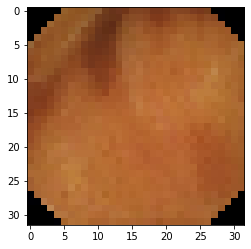

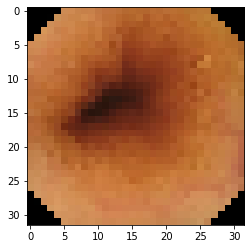

In [252]:
for image, label in labeled_ds.take(2):
    plt.figure()
    plt.imshow(image.numpy())
    #print(repr(image.numpy()))
    print(class_names[np.where(label)])

In [253]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_ds = labeled_ds
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [254]:
num_elements = tf.data.experimental.cardinality(full_ds).numpy()
print (num_elements)

44711


In [263]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# Create training dataset
train_ds = prepare_for_training(train_ds, cache="./train_ds.tfcache")
# Create test dataset
test_ds = prepare_for_training(test_ds, cache="./test_ds.tfcache")
# Create validation dataset
val_ds = prepare_for_training(val_ds, cache="./val_ds.tfcache")

In [264]:
train_dataset = train_ds
test_dataset = test_ds

In [257]:
tf.random.set_seed(22)
#train_dataset = train_dataset.map(augmentation).map(preprocess).shuffle(NUM_TRAIN_SAMPLES).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)
#test_dataset = test_dataset.map(preprocess).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)

input_shape = (32, 32, 3)
img_input = tf.keras.layers.Input(shape=input_shape)
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
    model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
      model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
      model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = TensorBoard(
  log_dir=log_dir,
  update_freq='batch',
  histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)


model.fit(train_dataset,
          epochs=NUM_EPOCHS,
          validation_data=test_dataset,
          validation_freq=1,
          callbacks=[tensorboard_callback, lr_schedule_callback])

Epoch 1/60
      1/Unknown - 10s 10s/step

InvalidArgumentError:  Cannot update variable with shape [] using a Tensor with shape [128], shapes must be equal.
	 [[node metrics/sparse_categorical_accuracy/AssignAddVariableOp (defined at /home/henrik/anaconda3/envs/TF2/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_582548]

Function call stack:
distributed_function


In [20]:
model.evaluate(test_dataset)

model.save('model.h5')

new_model = keras.models.load_model('model.h5')
 
new_model.evaluate(test_dataset)

53/53 [==============================] - 2s 45ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000


[0.0018190223534749646, 1.0]

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

Some parameters

In [ ]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('*/*.png')))

EPOCHS = 5
BATCH_SIZE = 128
IMG_HEIGHT = 32 #224
IMG_WIDTH = 32
STEPS_PER_EPOCH = np.ceil(DATASET_SIZE/BATCH_SIZE)

In [ ]:
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])

for classes in class_names:
    class_samples = len(list(data_dir.glob(classes+'/*.png')))
    print('{0:18}: {1:3d}'.format(classes, class_samples))

print ('\nTotal number of images:', DATASET_SIZE)

### Loading images with `tf.data.Dataset`.

In [ ]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

# Show some examples
for path in list_ds.take(5):
    print(path.numpy())

A short pure-tensorflow function that converts a file path to an `image_data, label` pair:

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Using `Dataset.map` to create a dataset of `Image, label` pairs:

In [ ]:
# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, IMG_HEIGHT + 8, IMG_WIDTH + 8)
    x = tf.image.random_crop(x, [IMG_HEIGHT, IMG_WIDTH, 3])
    x = tf.image.random_flip_left_right(x)
    return x, y

def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [ ]:
train_dataset = (labeled_ds
                 .map(augmentation)
                 .shuffle(buffer_size=500)
                 .map(normalize)
                 .batch(BATCH_SIZE, drop_remainder=True))

In [ ]:
model.compile(
          loss='sparse_categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

In [ ]:
model.fit(train_dataset,
          epochs=60,
          validation_data=test_ds,
          validation_freq=1)

In [ ]:
for image, label in labeled_ds.take(1):
    print ('Image shape: ', image.numpy().shape)
    print ('Label: ', label.numpy())

### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Split into training, test and validation dataset

In [ ]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_ds = labeled_ds
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [ ]:
num_elements = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements)

In [ ]:
# Create training dataset
train_ds = prepare_for_training(train_ds, cache="./train_ds.tfcache")
# Create test dataset
test_ds = prepare_for_training(test_ds, cache="./test_ds.tfcache")
# Create validation dataset
val_ds = prepare_for_training(val_ds, cache="./val_ds.tfcache")

In [ ]:
# Get one batch 
image_batch, label_batch = next(iter(train_ds))

# Display images in current batch
show_batch(image_batch.numpy(), label_batch.numpy())

## Traning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Create the model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])

Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch = train_size // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    validation_steps = val_size // BATCH_SIZE
)

Visualize training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()